<a href="https://colab.research.google.com/github/bdemchak/cytoscape-jupyter/blob/main/gangsu/basic_protocol_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This is a work-in-progress reproduction of the [Biological Network Exploration with Cytoscape 3](https://pubmed.ncbi.nlm.nih.gov/25199793/) Basic Protocol 2, which imports data from the Goh/Barabasi human disease network and displays it for exploration.


---
#Setup data files, py4cytoscape and Cytoscape connection
---
**NOTE: To run this notebook, you must manually start Cytoscape first -- don't proceed until you have started Cytoscape.**

---
##Setup: Import source data files

The network files are pre-positioned in GitHub, and are downloaded here for convenience. Once downloaded into the Python file system, they are downloaded into the Cytoscape sandbox for direct access by Cytoscape.

They really should be in web locations enables them to be downloaded directly by Cytoscape via a CyREST POST v1/networks call (assuming we can get Cytoscape itself to load directly from a URL). 


In [32]:
!rm -r Barabasi
!mkdir Barabasi

!rm -r output/
!mkdir output
!ls -l 
OUTPUT_DIR = 'output/'


total 16
drwxr-xr-x 2 root root 4096 May 10 19:03 Barabasi
drwxr-xr-x 2 root root 4096 May 10 17:48 logs
drwxr-xr-x 2 root root 4096 May 10 19:03 output
drwxr-xr-x 1 root root 4096 May  6 13:44 sample_data


---
##Setup: Fetch latest py4cytoscape




**Note that you can fetch from a specific github branch by adding "@<branch>" to the "py4cytocape" at the end of the github URL.**

For example, to get branch 0.0.5: git+https://github.com/cytoscape/py4cytoscape@0.0.5

In [33]:
!pip uninstall -y py4cytoscape

#!pip install py4cytoscape
!pip install git+https://github.com/cytoscape/py4cytoscape@0.0.9
#!pip install git+https://github.com/cytoscape/py4cytoscape

Uninstalling py4cytoscape-0.0.9:
  Successfully uninstalled py4cytoscape-0.0.9
  Cloning https://github.com/cytoscape/py4cytoscape (to revision 0.0.9) to /tmp/pip-req-build-vh1ge3vw
  Running command git clone -q https://github.com/cytoscape/py4cytoscape /tmp/pip-req-build-vh1ge3vw
  Running command git checkout -b 0.0.9 --track origin/0.0.9
  Switched to a new branch '0.0.9'
  Branch '0.0.9' set up to track remote branch '0.0.9' from 'origin'.
  Created wheel for py4cytoscape: filename=py4cytoscape-0.0.9-cp37-none-any.whl size=151116 sha256=edf09c30aab5984628c18e7f15562381b92ce7eab19b39fb1c8903d8bc017be4
  Stored in directory: /tmp/pip-ephem-wheel-cache-kbr0qtix/wheels/59/46/c2/a0aec2c0ac4c6c13dc3db0a92c9461235c144070fb50df0c0e
Successfully built py4cytoscape


---
##Setup: Set up Cytoscape connection


In [34]:
import IPython
import py4cytoscape as p4c
print(f'Loading Javascript client ... {p4c.get_browser_client_channel()} on {p4c.get_jupyter_bridge_url()}')
browser_client_js = p4c.get_browser_client_js(True)
IPython.display.Javascript(browser_client_js) # Start browser client


Loading Javascript client ... c6ea11ff-3573-4c92-a0f7-3fad80498078 on https://jupyter-bridge.cytoscape.org


<IPython.core.display.Javascript object>

---
#Sanity test to verify Cytoscape connection


In [35]:
p4c.cytoscape_version_info()


{'apiVersion': 'v1',
 'automationAPIVersion': '1.2.0',
 'cytoscapeVersion': '3.9.0-SNAPSHOT',
 'jupyterBridgeVersion': '0.0.2',
 'py4cytoscapeVersion': '0.0.9'}

---
# Position network files into Cytoscape's current sandbox

**Sandboxing is explained in https://py4cytoscape.readthedocs.io/en/latest/concepts.html#sandboxing**

In [36]:
barabasi = {}
barabasi['disease_net_txt'] = p4c.sandbox_url_to('https://github.com/bdemchak/cytoscape-jupyter/blob/main/gangsu/Barabasi/disease.net.txt', 'disease.net.txt')
barabasi['gene_net_txt'] = p4c.sandbox_url_to('https://github.com/bdemchak/cytoscape-jupyter/blob/main/gangsu/Barabasi/gene.net.txt', 'gene.net.txt')
barabasi['supp_tablesS2_txt'] = p4c.sandbox_url_to('https://github.com/bdemchak/cytoscape-jupyter/blob/main/gangsu/Barabasi/supplementary_tableS2.txt', 'supplementary_tableS2.txt')
barabasi['supp_tablesS3_txt'] = p4c.sandbox_url_to('https://github.com/bdemchak/cytoscape-jupyter/blob/main/gangsu/Barabasi/supplementary_tableS3.txt', 'supplementary_tableS3.txt')
barabasi['supp_tablesS4_txt'] = p4c.sandbox_url_to('https://github.com/bdemchak/cytoscape-jupyter/blob/main/gangsu/Barabasi/supplementary_tableS4.txt', 'supplementary_tableS4.txt')
for file, desc in barabasi.items():
  print(f"File: {file}, Bytes: {desc['fileByteCount']}, Path: {desc['filePath']}")


File: disease_net_txt, Bytes: 35861, Path: C:\Users\CyDeveloper\CytoscapeConfiguration\filetransfer\default_sandbox\disease.net.txt
File: gene_net_txt, Bytes: 197835, Path: C:\Users\CyDeveloper\CytoscapeConfiguration\filetransfer\default_sandbox\gene.net.txt
File: supp_tablesS2_txt, Bytes: 97916, Path: C:\Users\CyDeveloper\CytoscapeConfiguration\filetransfer\default_sandbox\supplementary_tableS2.txt
File: supp_tablesS3_txt, Bytes: 127626, Path: C:\Users\CyDeveloper\CytoscapeConfiguration\filetransfer\default_sandbox\supplementary_tableS3.txt
File: supp_tablesS4_txt, Bytes: 557710, Path: C:\Users\CyDeveloper\CytoscapeConfiguration\filetransfer\default_sandbox\supplementary_tableS4.txt



---
#Explore the protein-protein interaction network.

First, load the protein-protein network into Cytoscape.

This could take a few minutes because of the automatic force-directed layout.


In [37]:
p4c.close_session(False)
p4c.import_network_from_tabular_file('supplementary_tableS4.txt', first_row_as_column_names=True, start_load_row=2, column_type_list='x,s,x,t,i')


{'networks': [308953], 'views': [405134]}

##Layout and overlay information on the network

1.   Create a different colors for the edges representing different types of interactions.
2.   Make the nodes themselves transparent so edges are easier to see.
3.   For fun, create an image of the resulting network and display it in this notebook.


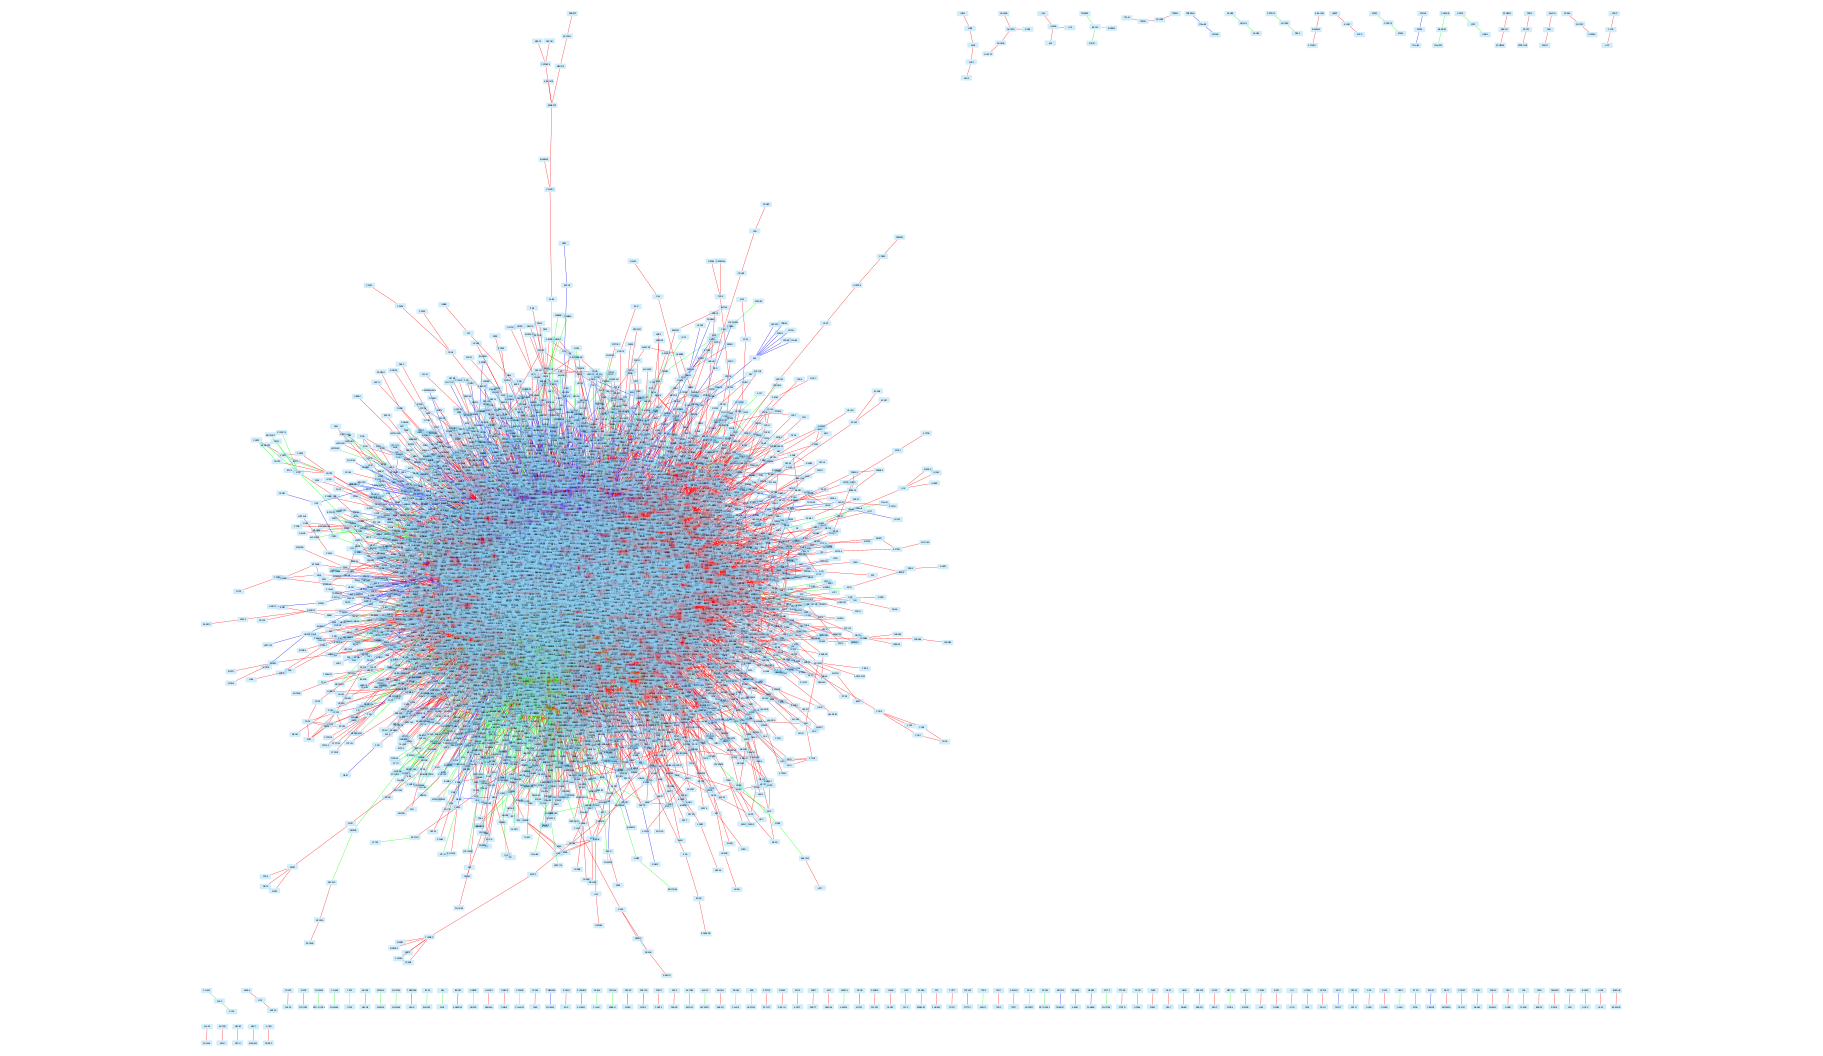

In [38]:
RED = '#ff0000'
GREEN = '#00ff00'
TEAL = '#00ffff'
PURPLE = '#ff00ff'
YELLOW = '#ffff00', 
BLUE = '#0000ff'
GREY = '#808080'

map = p4c.map_visual_property('EDGE_STROKE_UNSELECTED_PAINT', 'interaction', 'discrete', 
                              ['L', 'R', 'RL', 'RS', 'RSL', 'S', 'SL'], 
                              [RED, GREEN, TEAL, PURPLE, YELLOW, BLUE, GREY])
p4c.update_style_mapping('default', map)

p4c.set_node_fill_opacity_default(100, 'default')
p4c.toggle_graphics_details()

OUT_FILE = 'WholeNetwork.png'
p4c.export_image(OUT_FILE, overwrite_file=True)
p4c.sandbox_get_from(OUT_FILE, f'{OUTPUT_DIR}{OUT_FILE}')

from IPython.display import Image, display
display(Image(filename=f'{OUTPUT_DIR}{OUT_FILE}'))

## Discover local gene clusters using MCODE

Call MCODE to cluster genes using default settings, and then extract the second cluster into a network of its own.

For fun, export the network image and show it in this notebook.

{}


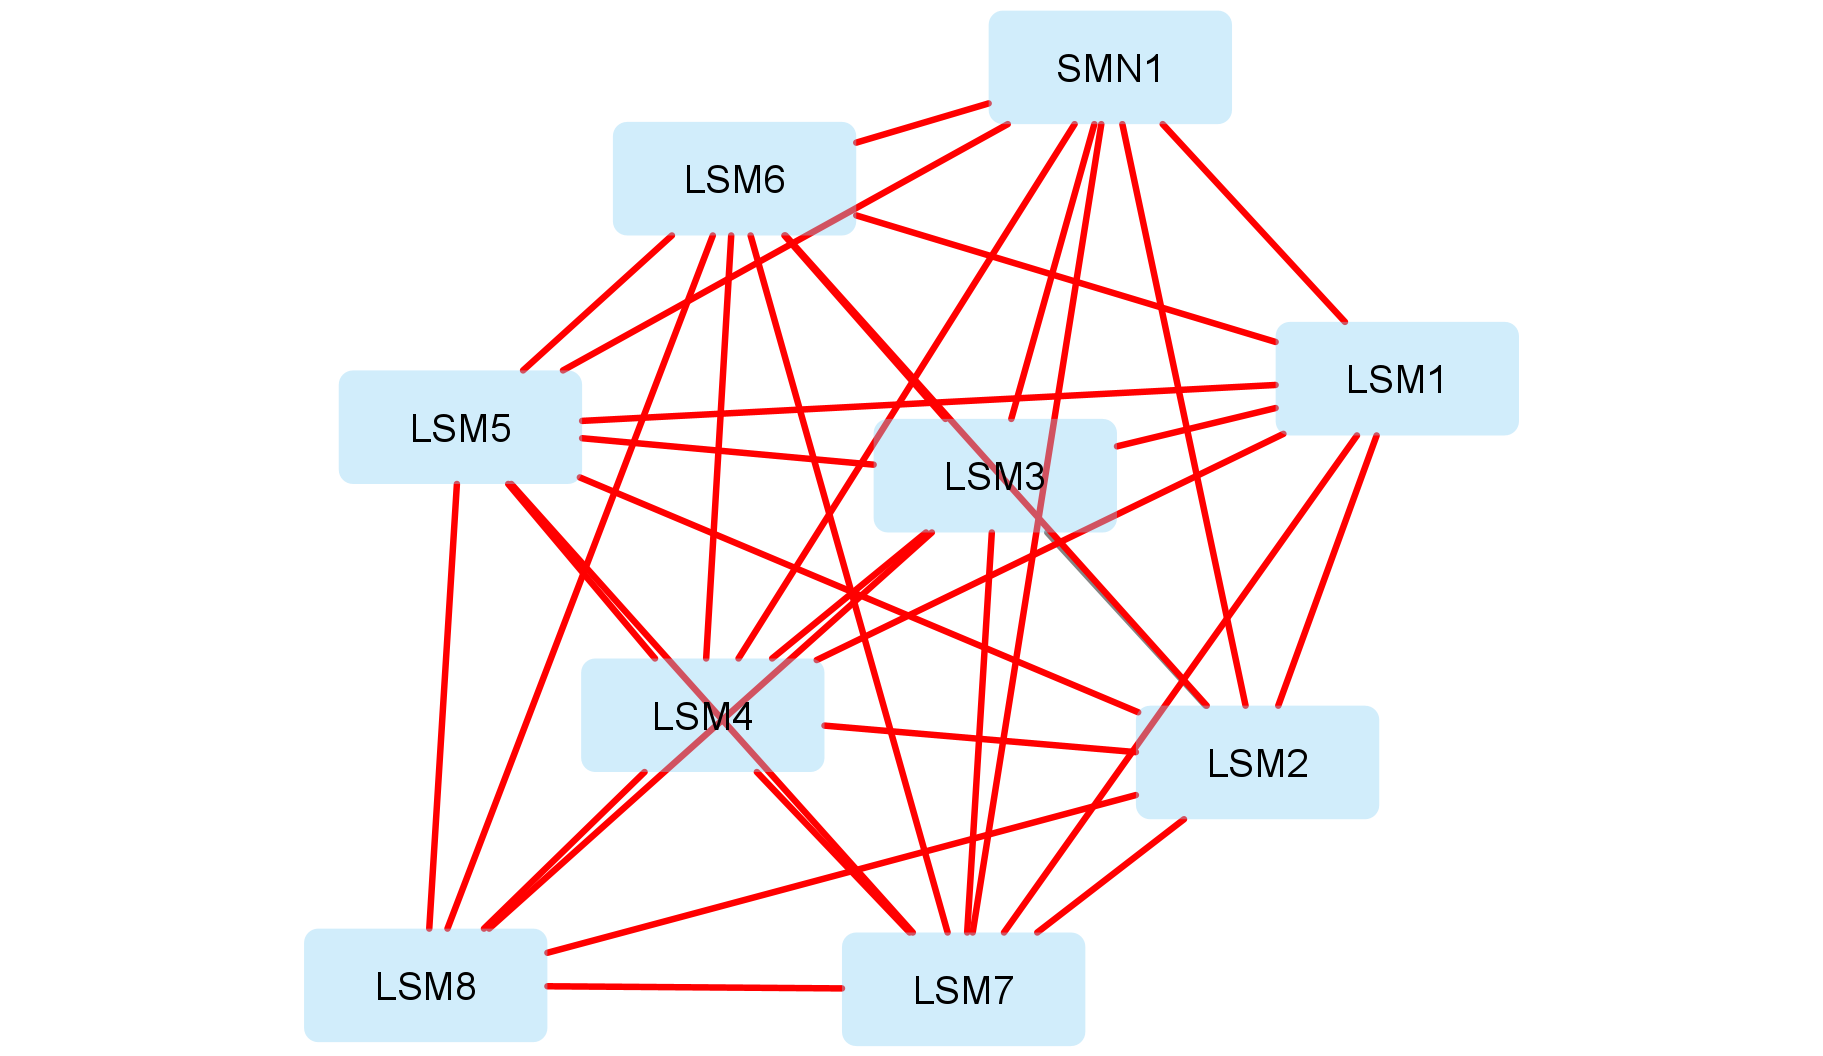

In [39]:
p4c.install_app('MCODE')
p4c.commands_post('mcode cluster network=""')
p4c.commands.commands_post('mcode view id=1 rank=2')

OUT_FILE = 'Cluster.png'
p4c.export_image(OUT_FILE, overwrite_file=True)
p4c.sandbox_get_from(OUT_FILE, f'{OUTPUT_DIR}{OUT_FILE}')

from IPython.display import Image, display
display(Image(filename=f'{OUTPUT_DIR}{OUT_FILE}'))

---
# Explore the human disease network

First, load the disease network into Cytoscape.

Note that the delimiter between values in the file is " "

In [40]:
p4c.close_session(False)
p4c.import_network_from_tabular_file('disease.net.txt', first_row_as_column_names=True, start_load_row=1, column_type_list='s,t,ea', delimiters=' ')



{'networks': [581191], 'views': [592988]}

Cytoscape interprets edges in the file as directional, and there are a lot of nodes in the disease file that are connected by two edges -- one in and one out.

For this demonstration, the directional distinction is meaningless, so remove in-bound edges that duplicate out-bound edges.

In [41]:
res = p4c.delete_duplicate_edges(ignore_direction=True)
if 'edges' in res:
  print(f'Edges removed: {len(res["edges"])}')
else:
  print('No edges removed')


Edges removed: 1527


## Annotate network with S2 table values

Use Pandas to parse the data because we need to rename the 'name' column to 'Disease Name' to avoid conflicts with the network's existing 'name' column.

Once that is done, we can import the annotations into the node table, keyed on the 'Disease ID' column. Note that Pandas would naturally import Disease ID as an int, but we coerce it to str to be compatible with the network's 'name' column.

In [42]:
p4c.sandbox_get_from('supplementary_tableS2.txt', 'Barabasi/supplementary_tableS2.txt')
import pandas as df
disease_table = df.read_csv('Barabasi/supplementary_tableS2.txt', sep='\t', header=1, dtype={'Disease ID':str})
disease_table.rename({'Name': 'Disease Name'}, axis=1, inplace=True)
disease_table

,Disease ID,Disease Name,Disorder class,Size (s),Degree (k),Class-degree (k),Genes implicated (Entrez ID) [comma-deliminated]
0,1,"17,20-lyase_deficiency",Endocrine,1,0,0,CYP17A1 (1586)
1,3,2-methyl-3-hydroxybutyryl-CoA_dehydrogenase_de...,Metabolic,1,0,0,HADH2 (3028)
2,4,2-methylbutyrylglycinuria,Metabolic,1,0,0,ACADSB (36)
3,5,"3-beta-hydroxysteroid_dehydrogenase,_type_II,_...",Metabolic,1,0,0,HSD3B2 (3284)
4,6,3-hydroxyacyl-CoA_dehydrogenase_deficiency,Metabolic,1,0,0,HADHSC (3033)
...,...,...,...,...,...,...,...
1279,8350,Combined_SAP_deficiency,Metabolic,1,2,2,PSAP (5660)
1280,9037,Multiple_myeloma,Cancer,2,1,0,"IRF4 (3662), LIG4 (3981)"
1281,9038,Multiple_sclerosis,Neurological,2,3,2,"CIITA (4261), PTPRC (5788)"
1282,9039,Multiple_sulfatase_deficiency,Metabolic,1,0,0,SUMF1 (285362)


In [43]:
p4c.load_table_data(disease_table, data_key_column='Disease ID')

/usr/local/lib/python3.7/dist-packages/py4cytoscape/tables.py:474: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_subset[col] = col_val


'Success: Data loaded in defaultnode table'

## Search for and select all nodes that have any attribute having to do with Neuro.

Create a filter that identifies the term `Neuro` in each description column, then create a composite filter that selects all nodes that match either filter.

In [44]:
p4c.create_column_filter('Find Neuro in Name', 'Disease Name', 'Neuro', 'CONTAINS', apply=False)
p4c.create_column_filter('Find Neuro in class', 'Disorder class', 'Neuro', 'CONTAINS', apply=False)
res = p4c.create_composite_filter('Find Neuro', ['Find Neuro in Name', 'Find Neuro in class'], type='ANY')
print(f'Nodes selected: {len(res["nodes"])}')

No nodes selected.
No edges selected.
No nodes selected.
No edges selected.
No edges selected.
Nodes selected: 86


## Randomly assign colors to each disease

Use Map Generator feature to identify unique values in the *Disorder class* column, then assign random node colors according to each value. As a result, different disorders have different colors.

In [45]:
p4c.set_node_color_mapping(**p4c.gen_node_color_map('Disorder class', p4c.scheme_color_random, style_name='default'))

''

## Create edge widths according to the number of neighbors

Use Map Generator feature to set the width of edges according to the edge Weight attribute. For Weight=1, use a width of 1, and for each higher Weight value, increase the width by 3. As a result, the edge width shows important node connections.

**Note:** To see edge weights in Cytoscape, you may have to zoom the graph display.


In [46]:
p4c.set_edge_line_width_mapping(**p4c.gen_edge_width_map('Weight', 
                                                         p4c.scheme_number_series, 
                                                         number_scheme_params={'start_value':1, 'step':3}, 
                                                         style_name='default'))

''

## Change node label to be disease name instead of disease number

In [47]:
node_label_map = p4c.map_visual_property('NODE_LABEL', 'Disease Name', 'passthrough')
p4c.update_style_mapping('default', node_label_map)


''

## Set node width and height to be proportional to Degree (k) column value

In [48]:
node_height_map = p4c.map_visual_property('NODE_HEIGHT', 'Degree (k)', 'continuous', [1, 50], [30, 300])
p4c.update_style_mapping('default', node_height_map)
node_width_map = p4c.map_visual_property('NODE_WIDTH', 'Degree (k)', 'continuous', [1, 50], [30, 300])
p4c.update_style_mapping('default', node_width_map)

''

## Show the resulting network for fun

So far, we have reproduced the visual style used in the [Goh poster](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1885563/bin/pnas_0701361104_9.pdf) for the [2007 Barabasi paper](https://pubmed.ncbi.nlm.nih.gov/17502601/) on human disease. 

For fun, we'll clean up the network by removing disconnected sub-networks and showing the result in this notebook.

## Toss all disconnected sub-networks

We start by identifying a node in the main network ... I chose node 812, which is Insomnia. To select the network containing 812, we use the Largest Subnetwork app, which has a function that selects the network containing 812, leaving the unconnected nodes unselected.

Next, we delete the disconnected nodes and re-size the network to fill the drawing space.

In [49]:
p4c.install_app('Largest Subnetwork')
res = p4c.commands_post('network select subnetwork createSubnetwork=false includesNode=812')
print(f'Count of nodes selected: {len(res["nodes"])}')

p4c.invert_node_selection()
p4c.delete_selected_nodes()
p4c.fit_content()



{}
Count of nodes selected: 516


{}

## Display the network

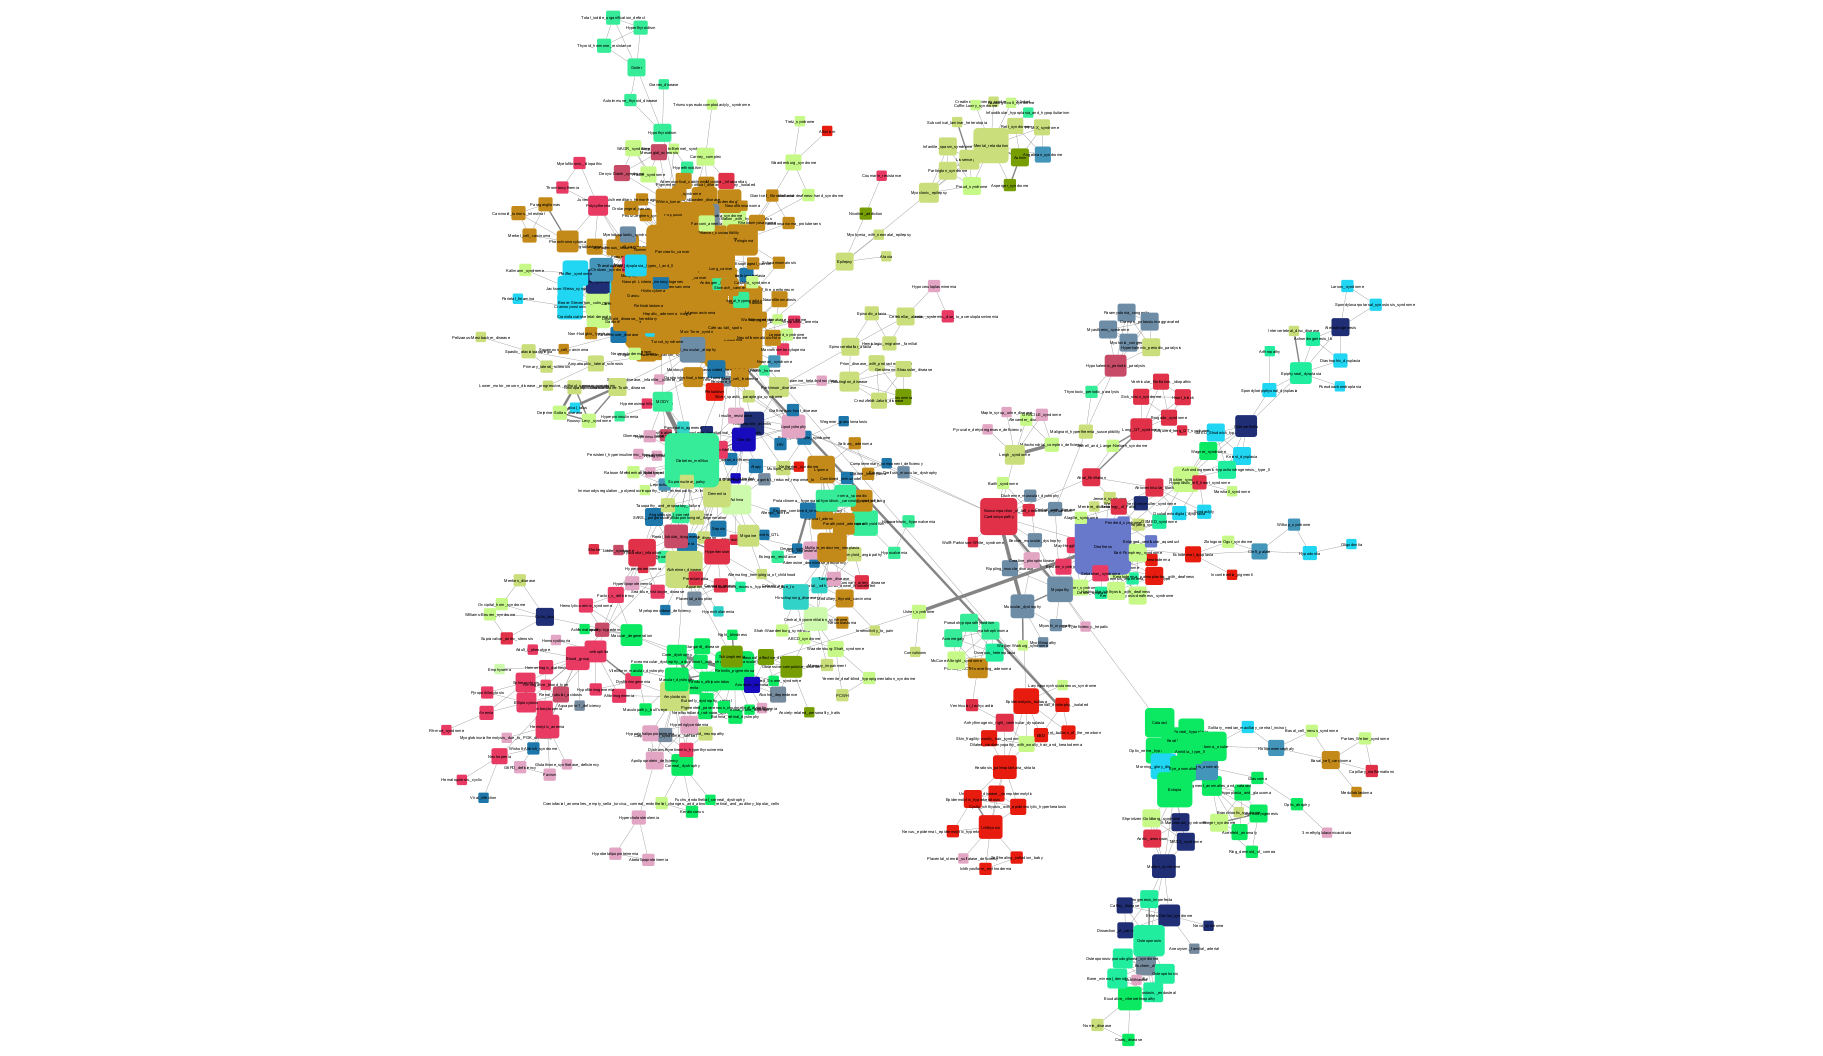

In [50]:
OUT_FILE = 'Disease.png'
p4c.export_image(OUT_FILE, overwrite_file=True)
p4c.sandbox_get_from(OUT_FILE, f'{OUTPUT_DIR}{OUT_FILE}')

from IPython.display import Image, display
display(Image(filename=f'{OUTPUT_DIR}{OUT_FILE}'))

## Upload the network in vector format

While a network in PNG format is easy to display on a web page, it's hard to see detail by zooming in, particularly this network. Upload the network in PDF format so it can be better zoomed in a PDF viewer. 

Use your browser to download Disease.pdf from your Colab workspace, then open it using your workstation's PDF viewer. Zooming will show node labels to be crisp and readable.

In [51]:
OUT_FILE = 'Disease.pdf'
p4c.export_image(OUT_FILE, type='PDF', overwrite_file=True)
p4c.sandbox_get_from(OUT_FILE, f'{OUTPUT_DIR}{OUT_FILE}')


{'fileByteCount': 70853,
 'filePath': 'C:\\Users\\CyDeveloper\\CytoscapeConfiguration\\filetransfer\\default_sandbox\\Disease.pdf',
 'modifiedTime': '2021-05-10 12:07:14.0992'}